In [2]:
!pip install networkx decorator

In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import openai, os

Scenario 1 - No resource (machine type and helpers or operators) constraints

In [18]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [35]:
data_scen1 = {
    "Task Number": [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65
    ],
    "Precedence Relation": [
        "-", "1", "2", "-", "4", "-", "3–5", "7", "6–8", "9", "10", "-", "-",
        "12-13", "14", "15", "-", "17", "18", "19", "20", "16-21", "22", "23",
        "11-24", "25", "26", "27", "-", "29", "30", "31", "32", "33", "28-34",
        "-", "36", "37", "38", "39", "35–40", "41", "42", "43", "-",
        "45", "46", "47", "48", "-",  "44-49-50", "51", "52", "53", "54", "55",
        "56", "-",  "57-58", "59",  "58", "60-61", "62", "63", "64"
    ],
    "ST (minute)": [
        0.315, 0.283, 0.929, 0.352, 0.198, 0.334, 0.577, 0.691, 0.701, 0.695,
        0.373, 0.214, 1.356, 0.534, 0.247, 0.927, 0.216, 0.187, 0.331, 0.240,
        0.421, 0.730, 0.582, 0.359, 0.432, 1.531, 1.091, 0.362, 0.235, 1.163,
        0.558, 0.238, 1.270, 1.652, 1.251, 0.403, 0.202, 0.221, 0.349, 0.392,
        1.721, 1.560, 0.658, 0.576, 0.076, 0.260, 0.151, 0.233, 0.095, 0.149,
        1.819, 1.129, 1.474, 1.685, 0.548, 0.355, 0.671, 0.142, 1.252, 0.523,
        0.164, 0.688, 0.884, 0.913, 0.895
    ]
}

print(data_scen1["ST (minute)"][0])
total_time = np.sum(data_scen1["ST (minute)"])


0.315


Calculation of performance indicators for the initial condition

In [36]:
n_stations = 61
CT = (8*60)/250 ##250 units required per day



min_n_stations = math.ceil(total_time / CT)

total_idle_time = (n_stations*CT) - total_time
balance_delay = 100*total_idle_time/(n_stations*CT) #%

line_efficiency = 100 - balance_delay #%

print(n_stations, CT, min_n_stations, total_idle_time, balance_delay, line_efficiency,total_time )

61 1.92 22 75.357 64.34170081967214 35.65829918032786 41.763


In [ ]:


# Convert to DataFrame
df = pd.DataFrame(data_scen1)
print(df)
# Number of tasks
num_tasks = len(df['Task Number'])


# Create a square matrix initialized with zeros
precedence_matrix = np.zeros((num_tasks, num_tasks), dtype=int)

# Function to update the matrix with precedence relations
def update_matrix(precedence, matrix, task_num):
    if precedence != '-':
        # Splitting the precedence string on standard dash
        predecessors = precedence.split('-')
        for pred in predecessors:
            if '–' in pred:  # Handling en dash within a range (e.g., "3–5")
                pred_ = [int(i) for i in pred.split('–')]
                for p in pred_:
                    matrix[p - 1, task_num - 1] = 1
            else:  # Handling individual tasks
                matrix[int(pred) - 1, task_num - 1] = 1
# Updating the matrix
for index, row in df.iterrows():
    update_matrix(row['Precedence Relation'], precedence_matrix, row['Task Number'])

# Convert matrix to DataFrame for better visualization or export
matrix_df = pd.DataFrame(precedence_matrix,
                         index=[f"{i+1}" for i in range(num_tasks)],
                         columns=[f"{i+1}" for i in range(num_tasks)])

# Add a star (*) to each component in the columns from the last '1' found to the top
for col in matrix_df.columns:
    last_one_index = None
    for i, value in enumerate(matrix_df[col]):
        if value == 1:
            last_one_index = i

    if last_one_index is not None:
        for j in range(last_one_index):
            if matrix_df.at[matrix_df.index[j], col] == 0:  # Add star only if the cell is not already '1'
                matrix_df.at[matrix_df.index[j], col] = '*'


matrix_df

    Task Number Precedence Relation  ST (minute)
0             1                   -        0.315
1             2                   1        0.283
2             3                   2        0.929
3             4                   -        0.352
4             5                   4        0.198
..          ...                 ...          ...
60           61                  58        0.164
61           62               60-61        0.688
62           63                  62        0.884
63           64                  63        0.913
64           65                  64        0.895

[65 rows x 3 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_18796\2744562607.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '*' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  matrix_df.at[matrix_df.index[j], col] = '*'


,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
1,0,1,*,0,*,0,*,*,*,*,...,*,*,0,*,*,*,*,*,*,*
2,0,0,1,0,*,0,*,*,*,*,...,*,*,0,*,*,*,*,*,*,*
3,0,0,0,0,*,0,1,*,*,*,...,*,*,0,*,*,*,*,*,*,*
4,0,0,0,0,1,0,*,*,*,*,...,*,*,0,*,*,*,*,*,*,*
5,0,0,0,0,0,0,1,*,*,*,...,*,*,0,*,*,*,*,*,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,*,*,*
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,*,*
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,*
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


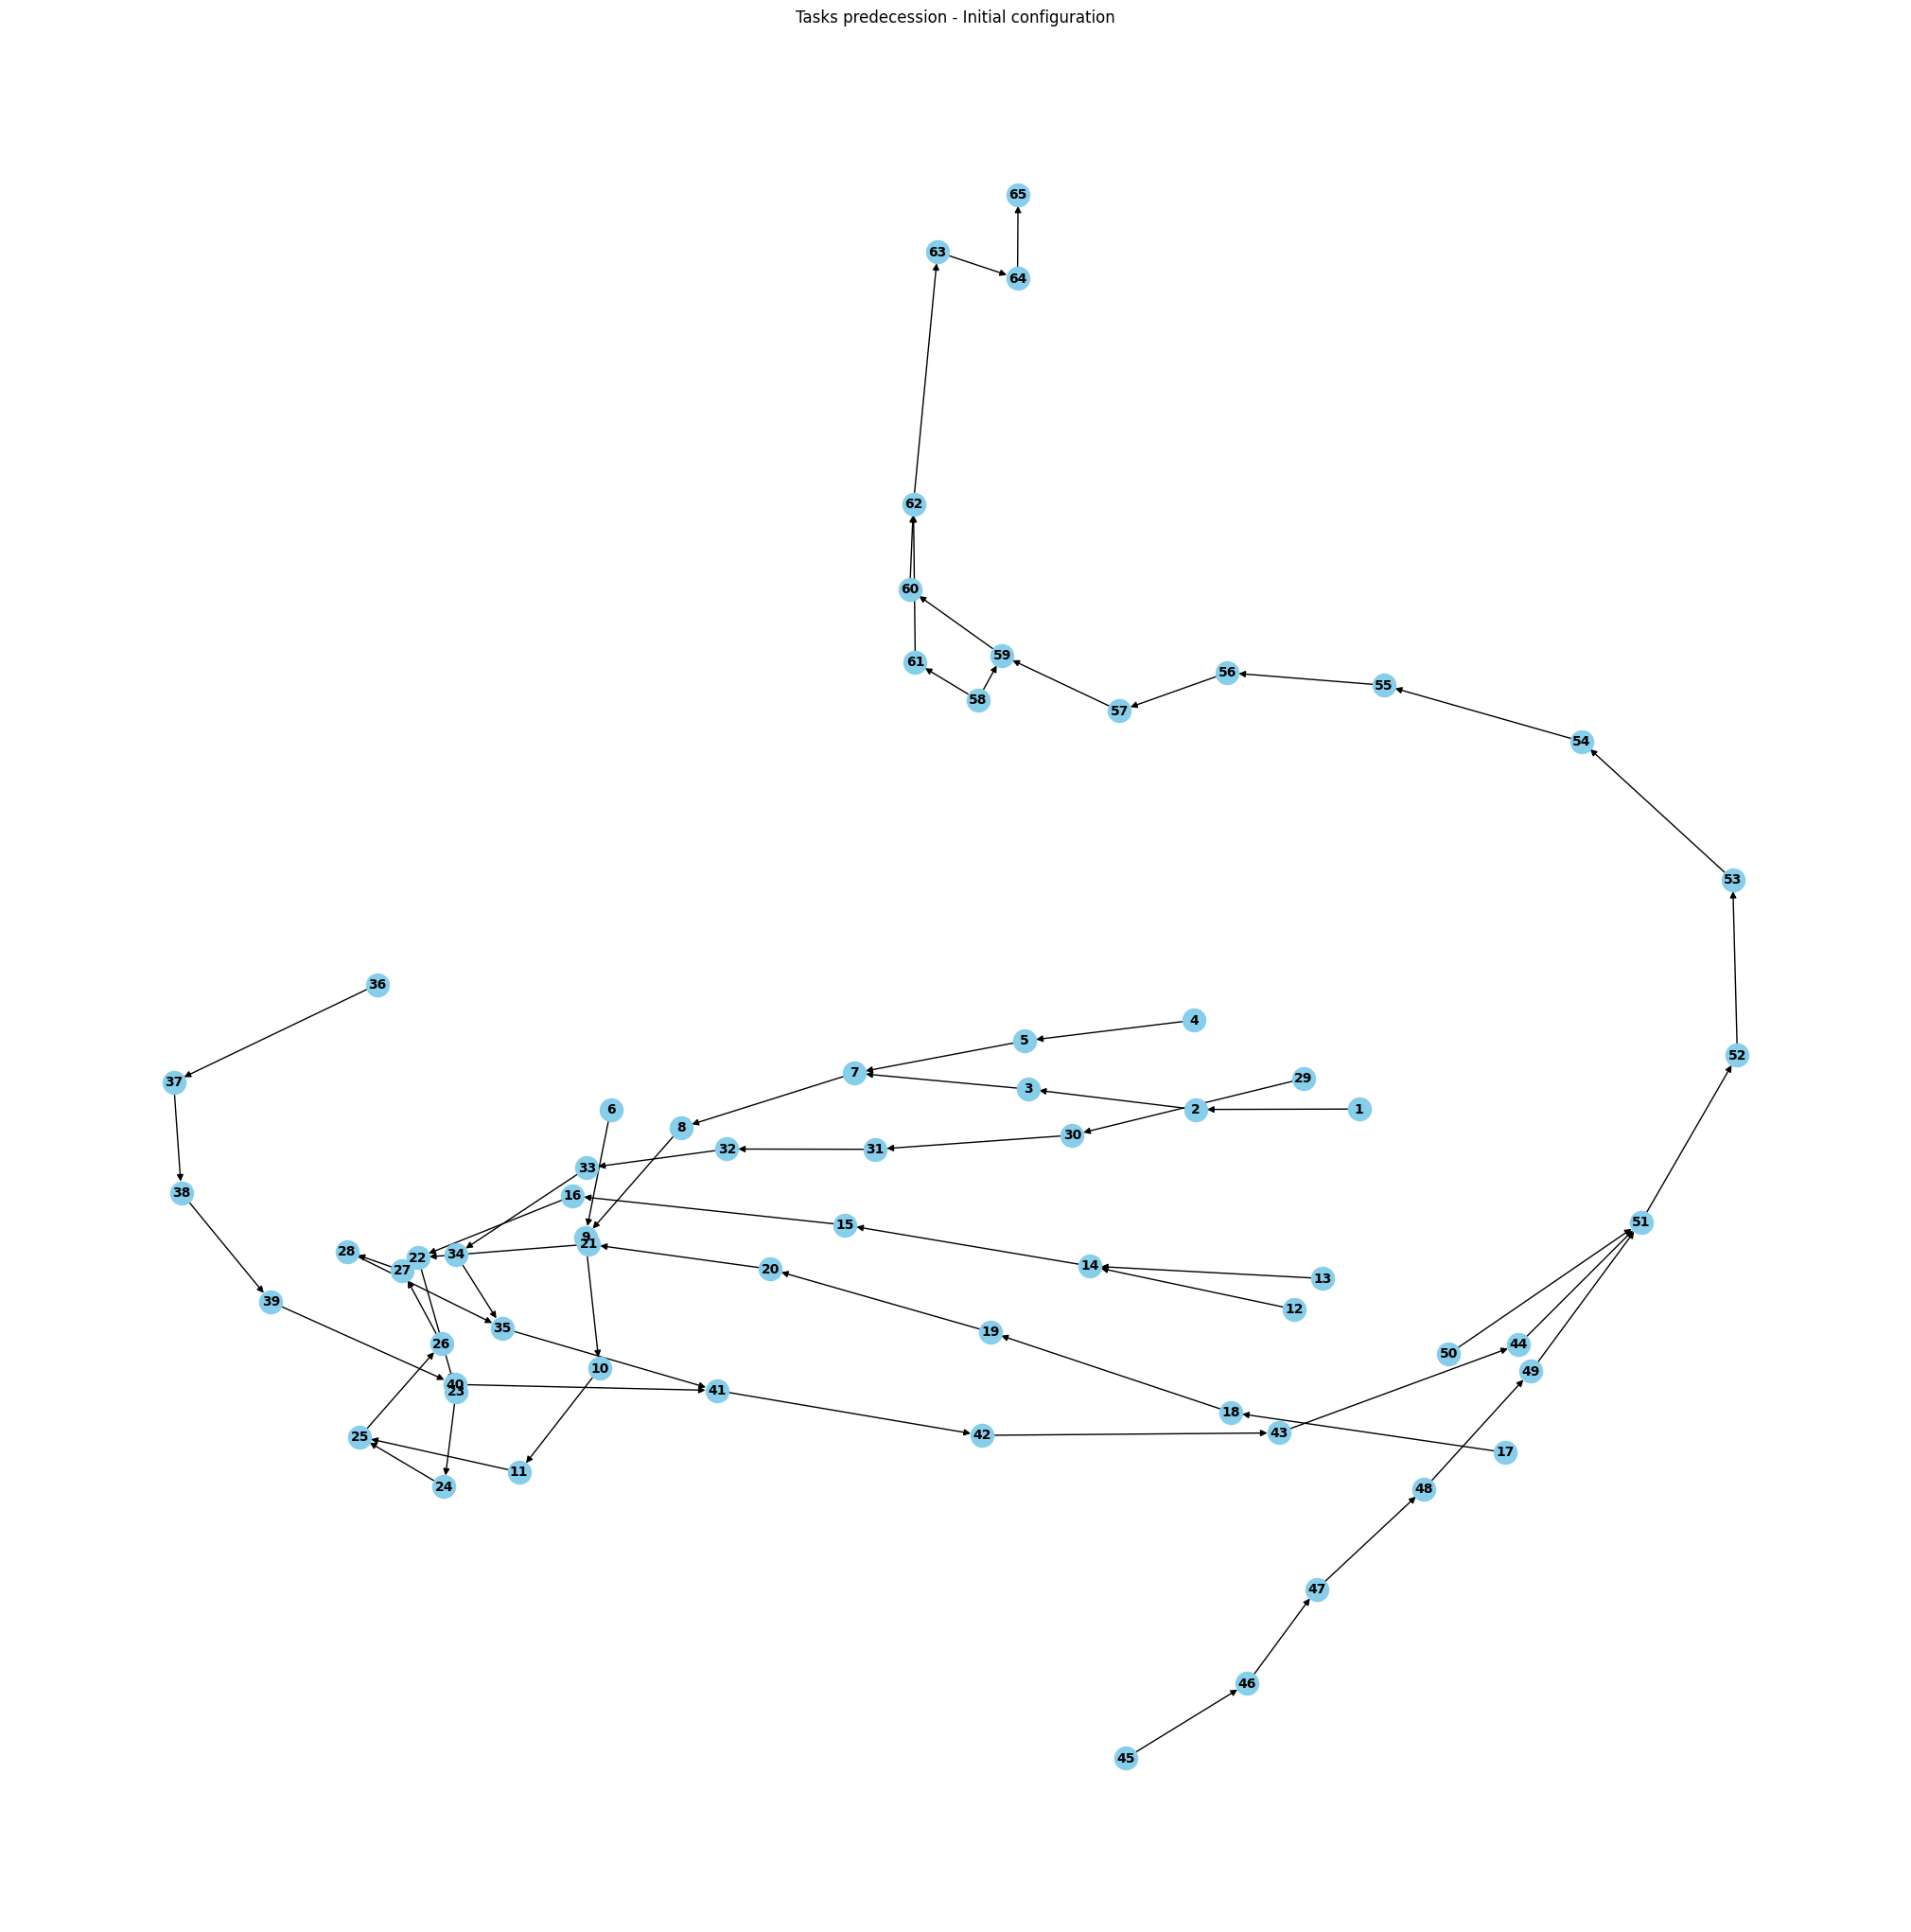

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
num_tasks = len(precedence_matrix)
G.add_nodes_from(range(1, num_tasks + 1))

# Add edges based on the precedence matrix
for i in range(num_tasks):
    for j in range(num_tasks):
        if precedence_matrix[i][j] == 1:
            G.add_edge(i + 1, j + 1)

# Plot the graph with a larger figure size
pos = nx.spring_layout(G)  # Layout algorithm
plt.figure(figsize=(20, 20))  # Adjust the figure size
nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=10, font_color="black", font_weight="bold")
plt.title("Tasks predecession - Initial configuration")
plt.savefig('Tasks predecession - Initial configuration.jpg')

In [ ]:
def calculate_rpw(task):
    if task not in G.nodes:
        return 0
    paths = list(nx.all_simple_paths(G, source=task, target=65))
    max_sum_st = 0
    for path in paths:
        sum_st = sum(df['ST (minute)'][task - 1] for task in path)
        if sum_st > max_sum_st:
            max_sum_st = sum_st
    return max_sum_st

# Calculate RPW for each task
rpw_values = {task: calculate_rpw(task) for task in G.nodes}

# print(G.nodes)

# Add RPW values to the 'matrix_df' DataFrame
matrix_df['RPW'] = [float(rpw_values.get(int(task), 0)) for task in matrix_df.index]

# Optionally export to Excel
matrix_df.to_excel('precedence_matrix_with_rpw.xlsx')
matrix_df

,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,RPW
1,0,1,*,0,*,0,*,*,*,*,...,*,0,*,*,*,*,*,*,*,26.582
2,0,0,1,0,*,0,*,*,*,*,...,*,0,*,*,*,*,*,*,*,26.267
3,0,0,0,0,*,0,1,*,*,*,...,*,0,*,*,*,*,*,*,*,25.984
4,0,0,0,0,1,0,*,*,*,*,...,*,0,*,*,*,*,*,*,*,25.605
5,0,0,0,0,0,0,1,*,*,*,...,*,0,*,*,*,*,*,*,*,25.253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,*,*,*,3.544
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,*,*,3.380
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,*,2.692
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.808


In [ ]:
# Sort tasks by RPW in descending order
sorted_tasks = [t+1 for t in np.argsort(matrix_df["RPW"])[::-1]]

s_t_c = sorted_tasks.copy()

print(sorted_tasks)

# Initialize variables
cycle_time = 1.92
workstation_schedule1 = [[]]
current_workstation1 = 0


# Create a directed graph
G2 = nx.DiGraph()

count_ = 0

while count_ < len(sorted_tasks):
    task = s_t_c[0]


    # Check if adding the task violates cycle time
    counter_ = 0
    task_time = data_scen1['ST (minute)'][task-1]
    A = [data_scen1['ST (minute)'][task_-1] for task_ in workstation_schedule1[current_workstation1]]


    if sum(A) + task_time < cycle_time:
        # Assign the task to the current workstation
        workstation_schedule1[current_workstation1].append(task)
        count_ += 1
        s_t_c = s_t_c[1:]



    else:
        current_workstation1 += 1
        workstation_schedule1.append([])


current_workstations_scen1 = len(workstation_schedule1)


print("Number of workstations after balancing for scenario 1:  ",  current_workstations_scen1)
print(workstation_schedule1)



[13, 1, 2, 3, 12, 4, 14, 5, 17, 7, 18, 15, 19, 16, 8, 20, 6, 21, 9, 29, 22, 30, 10, 23, 11, 24, 31, 25, 32, 26, 33, 34, 27, 28, 36, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 44, 47, 48, 50, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Number of workstations after balancing for scenario 1:   27
[[13, 1], [2, 3, 12, 4], [14, 5, 17, 7, 18], [15, 19, 16], [8, 20, 6, 21], [9, 29, 22], [30, 10], [23, 11, 24, 31], [25, 32], [26], [33], [34], [27, 28, 36], [35, 37, 38], [39, 40], [41], [42], [43, 45, 46, 44, 47], [48, 50, 49], [51], [52], [53], [54], [55, 56, 57, 58], [59, 60], [61, 62, 63], [64, 65]]


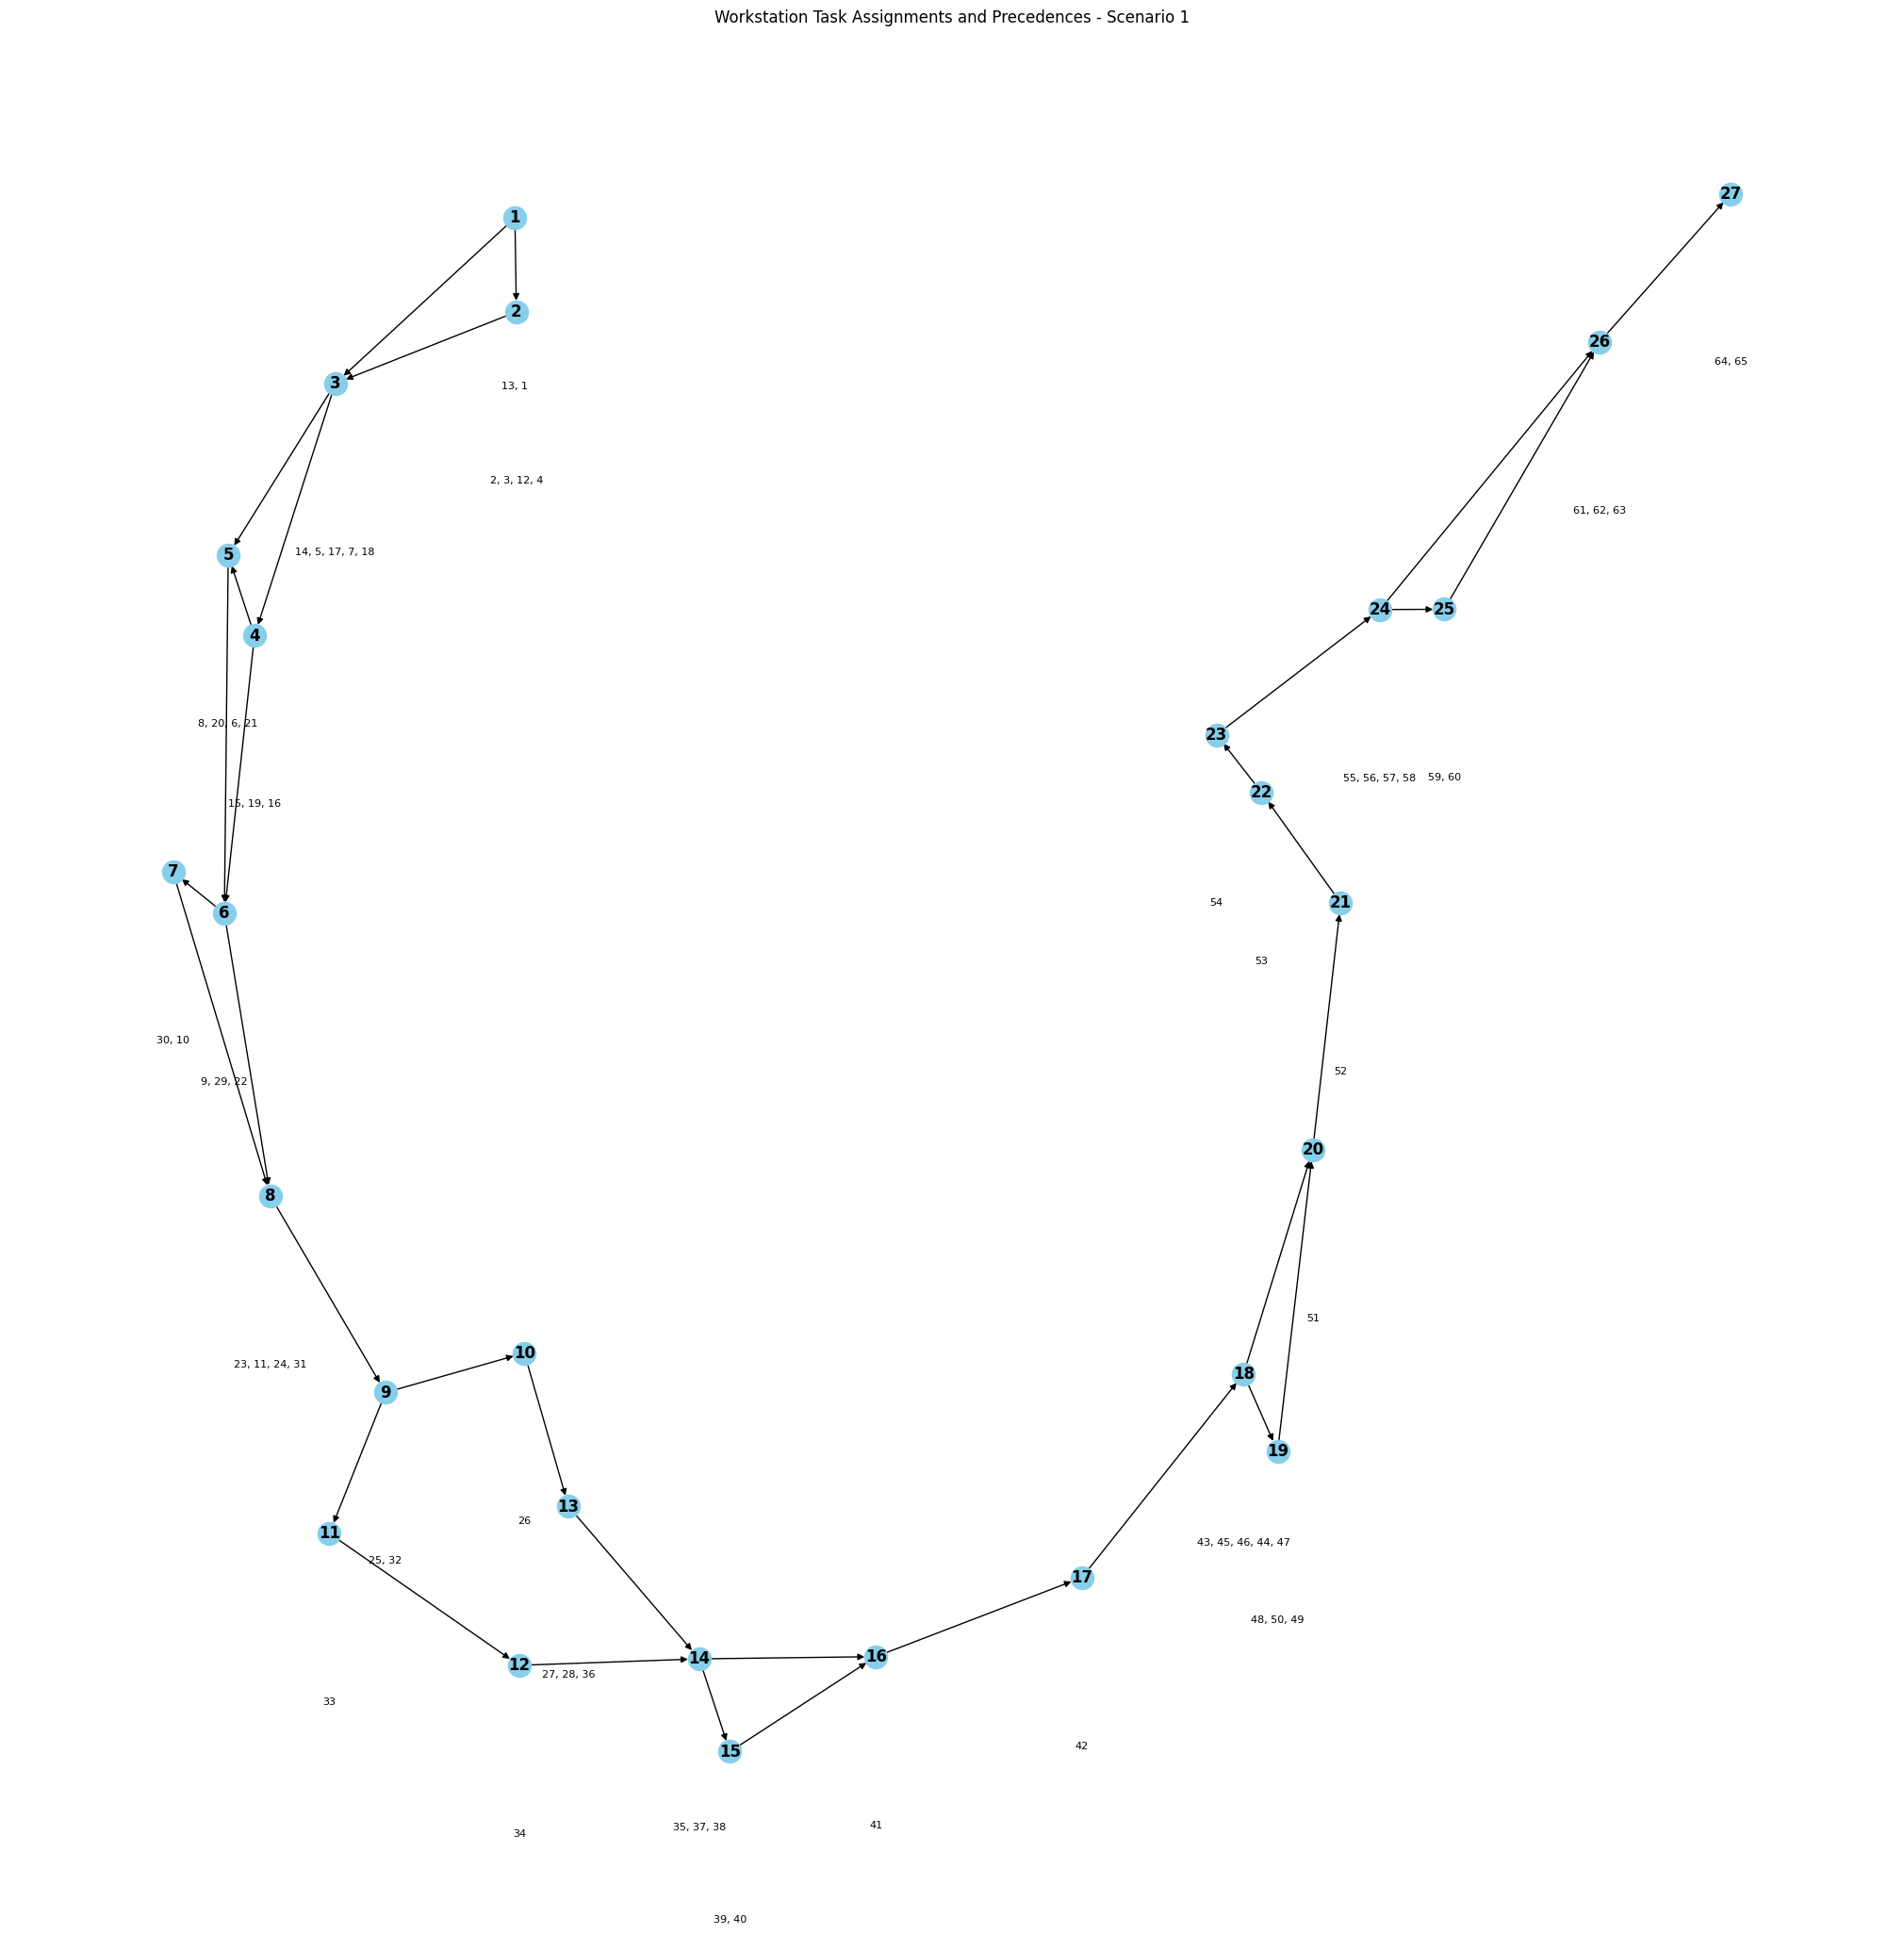

In [ ]:
# Create a directed graph
G2 = nx.DiGraph()

# Add nodes for each workstation
for i, workstation in enumerate(workstation_schedule1, start=1):
    G2.add_node(i, label=f"{', '.join(map(str, workstation))}")

# Function to find the workstation of a given task
def find_workstation(task, schedule):
    return next((i for i, ws in enumerate(schedule, start=1) if task in ws), None)

# Add edges based on task precedences
for i in range(len(precedence_matrix)):
    for j in range(len(precedence_matrix[i])):
        if precedence_matrix[i][j] == 1:
            task_i = i + 1
            task_j = j + 1
            workstation_i = find_workstation(task_i, workstation_schedule1)
            workstation_j = find_workstation(task_j, workstation_schedule1)
            if workstation_i and workstation_j and workstation_i != workstation_j:
                G2.add_edge(workstation_i, workstation_j)

# Use the spring_layout for better spacing
pos = nx.spring_layout(G2)

# Plot the graph
plt.figure(figsize=(20, 20))  # Adjust the figure size
nx.draw(G2, pos, node_size=300, node_color="skyblue", with_labels=True, font_color="black", font_weight="bold")

# Draw labels for each node (workstation) right under the nodes
for node, (x, y) in pos.items():
    label_y_offset = -0.12  # Adjust this value as needed to position labels
    plt.text(x, y + label_y_offset, s=nx.get_node_attributes(G2, 'label')[node], horizontalalignment='center', fontsize=8)

plt.title("Workstation Task Assignments and Precedences - Scenario 1")
plt.savefig("Workstation_assignment_graph_scenario1.jpg", format='jpg', bbox_inches='tight')
plt.show()

In [ ]:
total_idle_time_scen1 = current_workstations_scen1*CT - total_time
balance_delay_scen1 = 100*total_idle_time_scen1/(current_workstations_scen1*CT )
line_efficiency_scen1 = (100-balance_delay_scen1)

total_times_scen1 = [np.sum([data_scen1['ST (minute)'][task_-1] for task_ in ws ])for ws in workstation_schedule1]

TSmax_scen1 = np.max(total_times_scen1)

smoothness_index_scen1 = np.sqrt(np.sum([(Ti-TSmax_scen1)**2 for Ti in total_times_scen1 ]))
print(smoothness_index_scen1)

2.5437773094357143


Scenario 2 (Taking into account machine type constraints, human worker internvention...) :Saving tasks architecture as a dictionnary, this time taking into account the resource type constraints.Iterating through the "Resource" list and replacing "5O/L" and "3O/L" with "nO/L" for simplified work, as in the article "5O/L" and "3O/L" are considered as of same resource type

In [ ]:
data_scen2 = {
    "Task Number": [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65
    ],
    "Precedence Relation": [
        "-", "1", "2", "-", "4", "-", "3–5", "7", "6–8", "9", "10", "-", "-",
        "12-13", "14", "15", "-", "17", "18", "19", "20", "16-21", "22", "23",
        "11-24", "25", "26", "27", "-", "29", "30", "31", "32", "33", "28-34",
        "-", "36", "37", "38", "39", "35–40", "41", "42", "43", "-",
        "45", "46", "47", "48", "-",  "44-49-50", "51", "52", "53", "54", "55",
        "56", "-",  "57-58", "59",  "58", "60-61", "62", "63", "64"
    ],
    "ST (minute)": [
        0.315, 0.283, 0.929, 0.352, 0.198, 0.334, 0.577, 0.691, 0.701, 0.695,
        0.373, 0.214, 1.356, 0.534, 0.247, 0.927, 0.216, 0.187, 0.331, 0.240,
        0.421, 0.730, 0.582, 0.359, 0.432, 1.531, 1.091, 0.362, 0.235, 1.163,
        0.558, 0.238, 1.270, 1.652, 1.251, 0.403, 0.202, 0.221, 0.349, 0.392,
        1.721, 1.560, 0.658, 0.576, 0.076, 0.260, 0.151, 0.233, 0.095, 0.149,
        1.819, 1.129, 1.474, 1.685, 0.548, 0.355, 0.671, 0.142, 1.252, 0.523,
        0.164, 0.688, 0.884, 0.913, 0.895
    ],
    "Resource" : [
     "BH", "3O/L", "SN/L", "F/L", "5O/L", "5O/L", "SN/L", "SN/L", "SN/L", "SN/L",
     "Helper", "Helper", "Helper",  "SN/L", "AWM", "5O/L", "Helper", "BH","SN/L",
     "TM", "SN/L", "SN/L", "SN/L", "Helper", "Helper","5O/L", "F/A", "Helper", "Helper",
     "SN/L", "SN/L", "3O/L", "SN/L", "Iron press", "SN/L", "Helper", "BH","SN/L",
     "TM", "SN/L", "SN/L", "BT", "5O/L", "DN/L", "Helper", "SN/L", "TM",
     "SN/L",  "BH", "LM", "SN/L", "SN/L", "SN/L", "SN/L", "5O/L", "Helper", "F/A",
     "Helper", "SN/L", "BH","SN/L","SN/L","Helper","SN/L","BT"

]
}




print(len(data_scen2["Resource"]))
total_time = np.sum(data_scen1["ST (minute)"])


# Iterate through the "Resource" list and replace "5O/L" and "3O/L" with "nO/L" for simplified next, as in the article "5O/L" and "3O/L" are of same resource type
for i in range(len(data_scen2["Resource"])):
    if data_scen2["Resource"][i] == "5O/L" or data_scen2["Resource"][i] == "3O/L":
        data_scen2["Resource"][i] = "nO/L"


65


(Possible) Leveraging of LLM (GPT 4o model) for Automated Assembly Line Data Structuring from User Descriptions

In [39]:
import openai
import json



def intelligent_inference(user_input):
    """
Uses GPT-4o-mini to infer a complete assembly line structure based on user input,
directly returning structured data (`data_scen`) and calculated parameters.

This method is designed to simplify the process of defining complex assembly line structures.
It enables users to provide task details, precedence relations, and production requirements in natural language.
The system intelligently analyzes the input, infers missing details, recommends appropriate machine types,
and organizes precedence relations logically.

**Key Features:**
- Generates `data_scen`, a structured dictionary containing task numbers, precedence relations,
  standard times, and resource constraints (if there is any).



**Integration:**
The output of this method can be seamlessly integrated with existing workstation assignment algorithms.
The generated `data_scen` structureare formatted to be compatible
with methods like task scheduling, workstation balancing, and efficiency optimization.

**Args:**
    user_input (str): User input regarding tasks, precedence, and constraints.

**Returns:**
    dict: Structured data (`data_scen`).
"""

    # Step 1: Clarify ambiguous user input
    clarification_prompt = (
        "The following text describes the requirements of an assembly line but may contain ambiguous or incomplete elements. "
        "Please rephrase it to accurately reflect the intended professional specification, including any logically missing details if necessary. "
        "Do not provide any commentary; only give the reformulated and clarified text.\n\n"
        "Original Text: \"{user_input}\"\n\nClarified Text:"
    ).format(user_input=user_input)

    try:
        clarification_response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": clarification_prompt}],
            max_tokens=13000,
            temperature=0.7,
        )

        clarified_text = clarification_response['choices'][0]['message']['content'].strip()
        # print("\nClarified Input:\n", clarified_text)  # For debugging purposes

        # Step 2: Use clarified input to infer assembly line structure
        inference_prompt = (
            f"Based on the clarified input below, construct and return the following data in JSON format:\n"
            "- A dictionary `data_scen` with:\n"
            "  - 'Task Number': A list of task IDs (integers).\n"
            "  - 'Precedence Relation': Logical precedence relations for each task. Use '-' if no precedence, and use the format 'x-y-z' for multiple precedences.\n"
            "  - 'ST (minutes)': Standard times for tasks in minutes.\n"
            "  - 'Resource': Recommended machine types for each task (e.g., 'Soldering Station', 'Assembly Robot'). Pay careful attention to machine types and recommend appropriate ones based on task descriptions.\n"
            "- Additional parameters:\n"
            "  - 'n_stations': Number of workstations required (rounded to the nearest integer).\n"
            "  - 'production_requirement': Number of Units to be produced per day.\n"
            "  - 'hours_a_day': Number of Hours of Work per day (one daily shift base case).\n"


            "Analyze and organize the precedence relations, recommend them if not specified, and ensure the machine types are appropriate for each task.\n"
            "Use the clarified input to perform any necessary calculations. Return the data as JSON without any code block formatting, explanations, or extra text.\n\n"
            f"Clarified Input:\n{clarified_text}\n"
        )

        inference_response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": inference_prompt}],
            max_tokens=5000,
            temperature=0.7,
        )

        # Extract the JSON data
        json_data = inference_response['choices'][0]['message']['content'].strip()

        print("\nGenerated JSON Data:\n", json_data)  # For debugging

        # Remove any code block delimiters that may be present
        if json_data.startswith("```") and json_data.endswith("```"):
            json_data = json_data.strip("```").strip()
            # Remove 'json' language specifier if present
            if json_data.startswith("json"):
                json_data = json_data[4:].strip()

        # Parse the JSON data
        data = json.loads(json_data)

        # Extract the variables
        data_scen = data.get('data_scen', {})
        n_stations = data.get('n_stations')
        production_requirement = data.get('production_requirement')
        hours_a_day = data.get('hours_a_day')


        return {
            'data_scen': data_scen,

            'production_requirement': production_requirement,
            'hours_a_day' : hours_a_day


        }

    except Exception as e:
        print(f"Error during GPT-4 inference: {e}")
        return None

# Example complex user input
user_input = """
We are designing a new assembly line for producing denim jeans. The requirements are as follows:
- The assembly process should consist of approximately 50 tasks, but only a few key tasks are specified below.
- Task 1: Fabric cutting, no precedence, estimated duration 1.0 minute.
- Task 2: Pocket preparation, can be done after Task 1, duration 0.8 minutes.
- Task 3: Sewing front pockets, must follow Task 2, duration 1.2 minutes.
- Task 4: Sewing back pockets, must follow Task 2, duration 1.2 minutes.
- Task 5: Zipper attachment, depends on Task 3, duration 0.9 minutes.
- Task 6: Inseam stitching, can be done after Task 1, duration 1.5 minutes.
- Task 7: Outseam stitching, depends on Task 6, duration 1.5 minutes.
- Task 8: Waistband attachment, depends on Tasks 4, 5, and 7, duration 1.3 minutes.
- Task 9: Belt loop attachment, follows Task 8, duration 0.7 minutes.
- Task 10: Button and rivet attachment, follows Task 9, duration 0.5 minutes.
- Task 11: Hemming, follows Task 7, duration 0.8 minutes.
- Task 12: Final pressing, depends on Tasks 10 and 11, duration 1.0 minute.
- Task 13: Quality inspection, follows Task 12, duration 1.0 minute.
- Task 14: Packaging, follows Task 13, duration 0.6 minutes.
- Many inherent tasks are not listed but are necessary for the complete assembly process.
- Production requirement: 250 pairs of jeans per day.
- Daily working hours: 8 hours.
- Equipment recommendations are needed, but only specified for some tasks.
- Please analyze and recommend appropriate precedence relations for the missing tasks, include any inherent tasks that may have been overlooked, and ensure the machine types are suitable for each task.
- Note that several tasks may require the same type of machinery, such as sewing machines, cutting machines, and pressing equipment.
"""




# Run the inference
inferred_data = intelligent_inference(user_input)

if inferred_data:
    # Print the inferred variables
    print("\nInferred `data_scen`:")
    for key, value in inferred_data['data_scen'].items():
        print(f"{key}: {value}")
    print("\nAdditional Parameters:")

    print(f"production_requirement: {inferred_data.get('production_requirement')}")
    print(f"hours_a_day: {inferred_data.get('hours_a_day')}")


else:
    print("\nFailed to infer the assembly line structure.")



Generated JSON Data:
 {
  "data_scen": {
    "Task Number": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    "Precedence Relation": ["-", "1", "2", "2", "3", "1", "6", "4-5-7", "8", "9", "7", "10-11", "12", "13"],
    "ST (minutes)": [1.0, 0.8, 1.2, 1.2, 0.9, 1.5, 1.5, 1.3, 0.7, 0.5, 0.8, 1.0, 1.0, 0.6],
    "Resource": [
      "Cutting Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Sewing Machine",
      "Pressing Equipment",
      "Quality Control Station",
      "Packaging Station"
    ]
  },
  "n_stations": 5,
  "production_requirement": 250,
  "hours_a_day": 8
}

Inferred `data_scen`:
Task Number: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Precedence Relation: ['-', '1', '2', '2', '3', '1', '6', '4-5-7', '8', '9', '7', '10-11', '12', '13']
ST (minutes): [1.0, 0.8, 1.2, 1.2, 0.9, 1.5, 1.5,

In [ ]:
#Key parameters infered using the LLM - Do not excecute this cell as further adjustements may be required for using the LLM-guided apporach (variable names in the following workstation assignement algorithms)

data_scen_infered = inferred_data['data_scen']

total_time = np.sum(inferred_data['data_scen']["ST (minutes)"])

production_requirement = inferred_data.get('production_requirement')
hours_a_day = inferred_data.get('hours_a_day')

cycle_time = (hours_a_day*60)/production_requirement

Scenario

In [ ]:
s_t_c = sorted_tasks.copy()

workstation_schedule2_b = [[False, data_scen2["Resource"][s_t_c[0] - 1], s_t_c[0]]] #[status_workstation, resource_constraint, tasks_assigned], initiated by first task of sorted_tasks.

assigned_types = [data_scen2["Resource"][s_t_c[0]-1]]

s_t_c = s_t_c[1:]

status = [[i, False] for i in range(1, 66)] #status of each task, if assigned or not...
status[s_t_c[0]-1] = [s_t_c[0], True]

count2 = 1 #As first task by rank ordering is already assigned to first workstation by default

for task in s_t_c:




            corresponding_workstations = [i for i, val in enumerate(workstation_schedule2_b) if val[1] == data_scen2["Resource"][task-1] and not  val[0]]
            done_ = False

            if corresponding_workstations: #in case we indeed have found workstations not yet exhausted and with the same contraint type

                    for j in corresponding_workstations: #we'll be trying to assign the task to one of the corresponding workstations

                        if not status[task-1][1]:
                                WS_tasks = workstation_schedule2_b[j][2:]  # tasks that are already on the workstation.
                                A_1 = [data_scen2['ST (minute)'][task_-1] for task_ in WS_tasks]


                                task_time = data_scen2["ST (minute)"][task-1]
                                if (sum(A_1) + task_time) < cycle_time:

                                    workstation_schedule2_b[j].append(task)

                                    status[task-1][1] = True
                                    done_ = True





                    if not done_:  #in case none of the corresponding workstations was actually fit to have the task assigned to it.
                          workstation_schedule2_b.append([False, data_scen2["Resource"][task-1], task]) #we'll assign the task to a new, seperate workstation.







            else: #in case no fitting workstations were found

                        workstation_schedule2_b.append([False, data_scen2["Resource"][task-1], task])
                        status[task-1][1] = True



current_workstations_scen2 = len(workstation_schedule2_b)

print(sorted_tasks)
print(workstation_schedule2_b)





[13, 1, 2, 3, 12, 4, 14, 5, 17, 7, 18, 15, 19, 16, 8, 20, 6, 21, 9, 29, 22, 30, 10, 23, 11, 24, 31, 25, 32, 26, 33, 34, 27, 28, 36, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 44, 47, 48, 50, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
[[False, 'Helper', 13, 12, 17, 45], [False, 'BH', 1, 18, 37, 49, 60], [False, 'nO/L', 2, 5, 16, 6], [False, 'SN/L', 3, 14, 19], [False, 'F/L', 4], [False, 'SN/L', 7, 8, 21, 38], [False, 'AWM', 15], [False, 'TM', 20, 39, 47], [False, 'SN/L', 9, 22, 40], [False, 'Helper', 29, 11, 24, 25, 28, 58], [False, 'SN/L', 30, 10], [False, 'SN/L', 23, 31, 46, 48, 61], [False, 'nO/L', 32, 26], [False, 'SN/L', 33], [False, 'Iron press', 34], [False, 'F/A', 27, 57], [False, 'Helper', 36, 56, 63], [False, 'SN/L', 35], [False, 'SN/L', 41], [False, 'BT', 42], [False, 'nO/L', 43, 55], [False, 'DN/L', 44], [False, 'LM', 50], [False, 'SN/L', 51], [False, 'SN/L', 52, 62], [False, 'SN/L', 53], [False, 'SN/L', 54], [False, 'SN/L', 59], [False, 'SN/L', 64], [False

In [ ]:
total_idle_time_scen2 = current_workstations_scen2*CT - total_time
balance_delay_scen2 = 100*total_idle_time_scen2/(current_workstations_scen2*CT )
line_efficiency_scen2 = (100-balance_delay_scen2)

total_times_scen2 = [np.sum([data_scen2['ST (minute)'][task_-1] for task_ in ws[2:] ])for ws in workstation_schedule2_b]

TSmax_scen2 = np.max(total_times_scen2)

smoothness_index_scen2 = np.sqrt(np.sum([ (Ti-TSmax_scen2)**2 for Ti in total_times_scen2 ]))



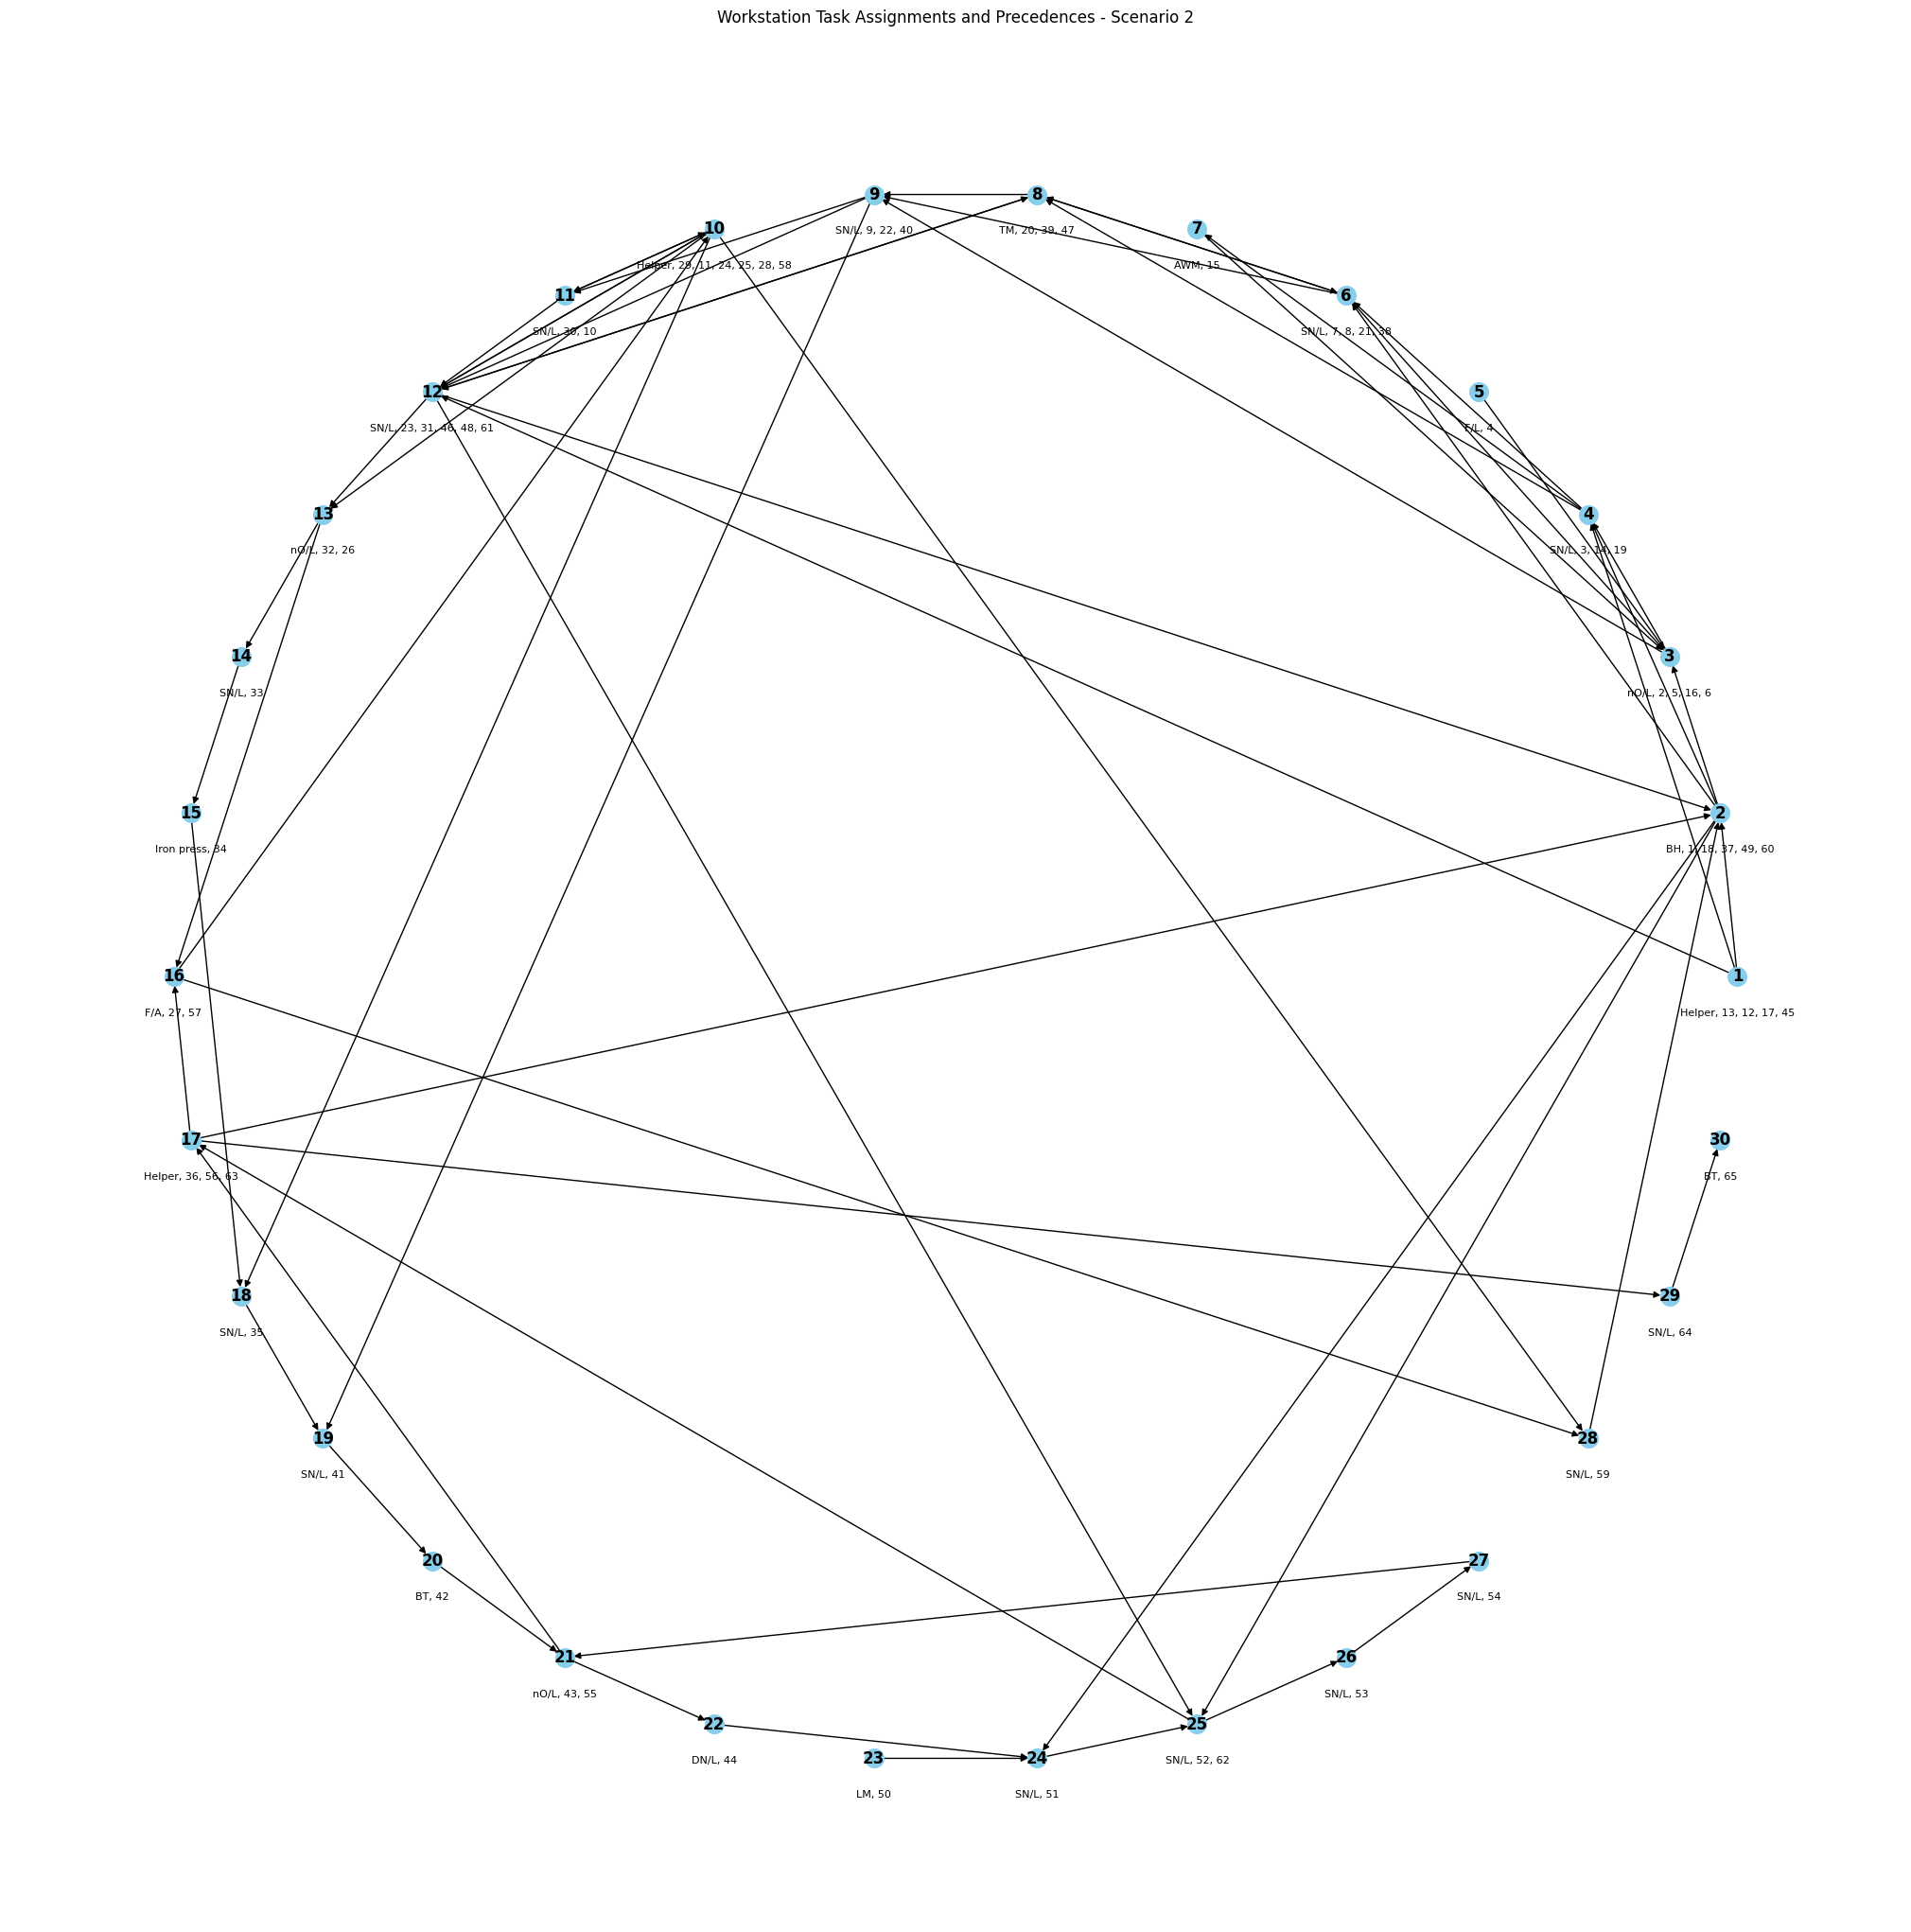

In [ ]:
# Create a directed graph
G3 = nx.DiGraph()

# Add nodes for each workstation
for i, workstation in enumerate(workstation_schedule2_b, start=1):
    G3.add_node(i, label=f"{', '.join(map(str, workstation[1:]))}")

# Function to find the workstation of a given task
def find_workstation(task, schedule):
    return next((i for i, ws in enumerate(schedule, start=1) if task in ws), None)

# Add edges based on task precedences
for i in range(len(precedence_matrix)):
    for j in range(len(precedence_matrix[i])):
        if precedence_matrix[i][j] == 1:
            task_i = i + 1
            task_j = j + 1
            workstation_i = find_workstation(task_i, workstation_schedule2_b)
            workstation_j = find_workstation(task_j, workstation_schedule2_b)
            if workstation_i and workstation_j and workstation_i != workstation_j:
                G3.add_edge(workstation_i, workstation_j)


pos = nx.circular_layout(G3)

# Plot the graph
plt.figure(figsize=(20, 20))  # Adjust the figure size
nx.draw(G3, pos, node_size=200, node_color="skyblue", with_labels=True, font_color="black", font_weight="bold")

# Draw labels for each node (workstation) right under the nodes
for node, (x, y) in pos.items():
    label_y_offset = -0.05  # Adjust this value as needed to position labels
    plt.text(x, y + label_y_offset, s=nx.get_node_attributes(G3, 'label')[node], horizontalalignment='center', fontsize=8)

plt.title("Workstation Task Assignments and Precedences - Scenario 2")
plt.savefig("Workstation_assignment_graph_scenario2.jpg", format='jpg', bbox_inches='tight')
plt.show()

Table comparing results of both scenarios:

In [ ]:
# Table headers
print(f'{"Metric":<30}{"Scenario 1":<20}{"Scenario 2":<20}')

# Data rows
print(f'{"Number of Workstations":<30}{current_workstations_scen1:<20}{current_workstations_scen2:<20}')
print(f'{"Smoothness Index":<30}{smoothness_index_scen1:<20}{smoothness_index_scen2:<20}')  # Assuming these are float
print(f'{"Line Efficiency":<30}{line_efficiency_scen1:<20}{line_efficiency_scen2:<20}')  # Assuming these are float
print(f'{"Balance Delay":<30}{balance_delay_scen1:<20}{balance_delay_scen2:<20}')
print(f'{"Total Idle Time":<30}{total_idle_time_scen1:<20}{total_idle_time_scen2:<20}')


Metric                        Scenario 1          Scenario 2          
Number of Workstations        27                  30                  
Smoothness Index              2.5437773094357143  4.0308893559610395  
Line Efficiency               80.5613425925926    72.50520833333334   
Balance Delay                 19.438657407407405  27.49479166666666   
Total Idle Time               10.076999999999998  15.836999999999996  
